<a href="https://colab.research.google.com/github/YUCHIAO-SHIH/CNN_CIFAR10/blob/main/(Net)CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 匯入套件
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib.pylab import plt
import PIL
import torch.nn.functional as F
from google.colab import drive

from torch.utils.data import DataLoader, random_split

In [3]:
# 檢查 GPU 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# drive.mount('/content/drive')

In [37]:
# # 重新定義模型
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Net().to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/model.pth"))
# model.eval()  # 將模型設置為評估模式
# print("Model parameters loaded from model.pth")


# # 從 Google 雲端硬碟載入訓練歷史紀錄
# with open("/content/drive/MyDrive/training_history.pkl", "rb") as f:
#     history = pickle.load(f)

# # 提取歷史紀錄
# train_loss = history['train_loss']
# train_acc = history['train_acc']
# val_loss = history['val_loss']
# val_acc = history['val_acc']
# test_acc = history['test_acc']

# print("Training history loaded from training_history.pkl")

Model parameters loaded from model.pth
Training history loaded from training_history.pkl


<ipython-input-37-fbbb1c43766c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/model.pth"))


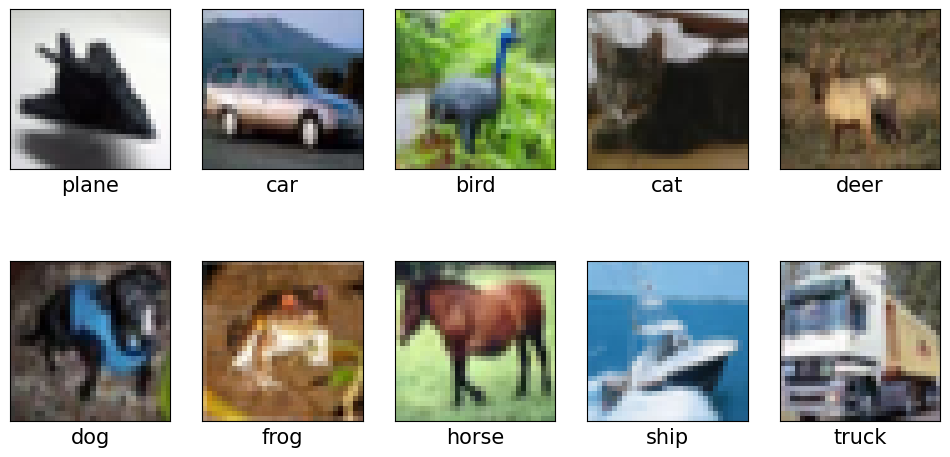

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [train_set.dataset.data[np.asarray(train_set.dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1
plt.savefig("/content/drive/MyDrive/eda.png", dpi=300)

In [28]:
# 定義類別標籤
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def visualize(model, data_loader, classes, save_path='/content/drive/MyDrive/visualization.png'):
    # 取得一批數據
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # 將模型設置為評估模式
    model.eval()

    # 顯示真實標籤
    print(f'Labels: {" ".join(f"{classes[label]:>5s}" for label in labels[:5])}')

    # 模型預測
    predict = model(images.to(device)).cpu()  # 把訓練資料送到GPU上，再把預測機率送回主記憶體
    pred_label = torch.max(predict.data, 1).indices
    print(f'Predictions: {" ".join(f"{classes[label]:>5s}" for label in pred_label[:5])}')

    # 清空 GPU 記憶體快取
    torch.cuda.empty_cache()

    # 繪製圖像與預測機率
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 8))
    plt.subplots_adjust(wspace=1, hspace=0.5)

    for i in range(5):
        # 顯示圖片
        img = images[i] * 0.5 + 0.5  # 去標準化
        axes[0][i].imshow(img.permute(1, 2, 0).numpy())
        axes[0][i].axis('off')

        # 繪製預測機率條形圖
        y = torch.softmax(predict.data[i], 0).numpy()
        axes[1][i].barh(range(10), y)
        axes[1][i].set_yticks(range(10))
        axes[1][i].set_yticklabels(classes)
        axes[1][i].invert_yaxis()  # 類別從上到下顯示

        # 在每條條形上顯示數值
        for j, v in enumerate(y):
            axes[1][i].text(v + 0.01, j, f"{v:.4f}", color='black')
     # 保存圖像
    #plt.savefig("/content/drive/MyDrive/LOSS_curve.png", dpi=300)
    plt.savefig(save_path, dpi=300)
    print(f"Visualization saved as {save_path}")


    plt.show()

In [6]:
# 假設您的模型名稱是 Net，並已經定義好
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定義模型層
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.bn_dense2 = nn.BatchNorm1d(512)
        self.dropout_conv = nn.Dropout2d(p=0.25)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def conv_layers(self, x):
        x = F.relu(self.bn_conv1(self.conv1(x)))
        x = F.relu(self.bn_conv2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        x = F.relu(self.bn_conv3(self.conv3(x)))
        x = F.relu(self.bn_conv4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        return x

    def dense_layers(self, x):
        x = F.relu(self.bn_dense1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_dense2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 256 * 8 * 8)
        x = self.dense_layers(x)
        return x

In [7]:
# 測試函數
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 訓練函數
def train(model, epochs, train_loader, val_loader, test_loader, optimizer, criterion, device, batch_size):
    train_loss, train_acc, val_loss, val_acc, test_acc = [], [], [], [], []

    for e in range(epochs):
        model.train()
        loss_sum, correct_cnt = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_cnt += (predicted == labels).sum().item()

        # 記錄訓練損失和準確率
        train_loss.append(loss_sum / len(train_loader))
        train_acc.append(correct_cnt / len(train_loader.dataset))

        # 驗證階段
        model.eval()
        val_loss_sum, val_correct_cnt = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss_epoch = criterion(outputs, labels)
                val_loss_sum += val_loss_epoch.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_cnt += (predicted == labels).sum().item()

        # 記錄驗證損失和準確率
        val_loss.append(val_loss_sum / len(val_loader))
        val_acc.append(val_correct_cnt / len(val_loader.dataset))

        # 測試階段
        test_loss_epoch, test_accuracy_epoch = test(model, test_loader, criterion, device)
        test_acc.append(test_accuracy_epoch)  # 記錄測試準確率

        print(f'Epoch {e+1}/{epochs} - '
              f'Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f} - '
              f'Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f} - '
              f'Test Acc: {test_acc[-1]:.4f}')

    return train_loss, train_acc, val_loss, val_acc, test_acc

In [8]:
# 設置數據加載器和訓練參數
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#])
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), interpolation=PIL.Image.BILINEAR), # Changed resample to interpolation
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# 初始化模型、損失函數、優化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)



In [12]:
print(model)

Net(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn_conv1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dense1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dense2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_conv): Dropo

In [17]:
# 執行訓練
train_loss, train_acc, val_loss, val_acc, test_acc = train(
    model, epochs=100, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
    optimizer=optimizer, criterion=criterion, device=device, batch_size=64
)

Epoch 1/100 - Train Loss: 1.6210, Train Acc: 0.4072 - Val Loss: 1.2993, Val Acc: 0.5281 - Test Acc: 0.5531
Epoch 2/100 - Train Loss: 1.2899, Train Acc: 0.5343 - Val Loss: 1.0486, Val Acc: 0.6207 - Test Acc: 0.6552
Epoch 3/100 - Train Loss: 1.1131, Train Acc: 0.6037 - Val Loss: 0.9338, Val Acc: 0.6671 - Test Acc: 0.6773
Epoch 4/100 - Train Loss: 1.0100, Train Acc: 0.6432 - Val Loss: 0.8614, Val Acc: 0.6963 - Test Acc: 0.7153
Epoch 5/100 - Train Loss: 0.9410, Train Acc: 0.6668 - Val Loss: 0.7875, Val Acc: 0.7260 - Test Acc: 0.7392
Epoch 6/100 - Train Loss: 0.8791, Train Acc: 0.6927 - Val Loss: 0.7697, Val Acc: 0.7315 - Test Acc: 0.7332
Epoch 7/100 - Train Loss: 0.8403, Train Acc: 0.7060 - Val Loss: 0.7098, Val Acc: 0.7560 - Test Acc: 0.7576
Epoch 8/100 - Train Loss: 0.7972, Train Acc: 0.7202 - Val Loss: 0.6916, Val Acc: 0.7614 - Test Acc: 0.7485
Epoch 9/100 - Train Loss: 0.7564, Train Acc: 0.7372 - Val Loss: 0.6576, Val Acc: 0.7715 - Test Acc: 0.7834
Epoch 10/100 - Train Loss: 0.7284, Tr

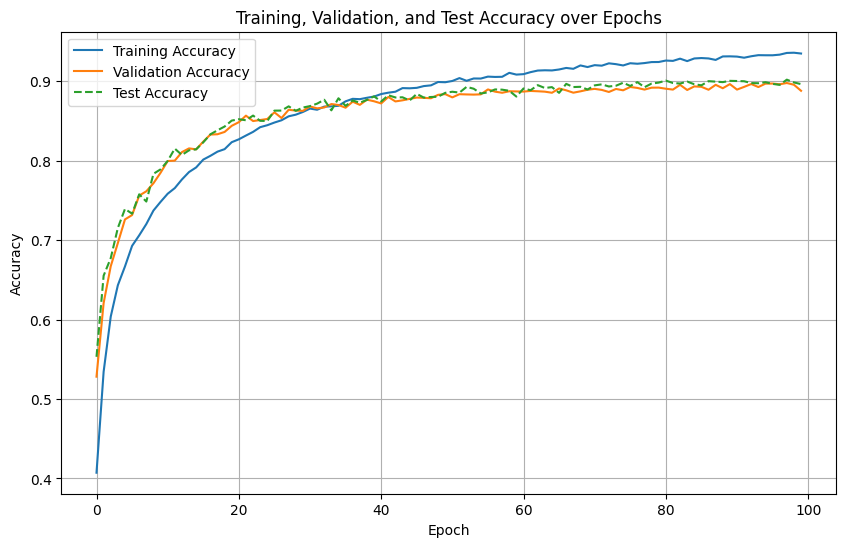

In [38]:
# 繪製準確率曲線(在content 那邊)
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(test_acc, label='Test Accuracy', linestyle='--')  # 每個 epoch 的測試準確率

plt.title('Training, Validation, and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
# 保存圖片
# 保存到 Google 雲端硬碟中的指定位置
plt.savefig("/content/drive/MyDrive/accuracy_curve.png", dpi=300)
#plt.savefig("accuracy_curve.png", dpi=300)  # dpi=300 可提高圖片解析度
plt.show()



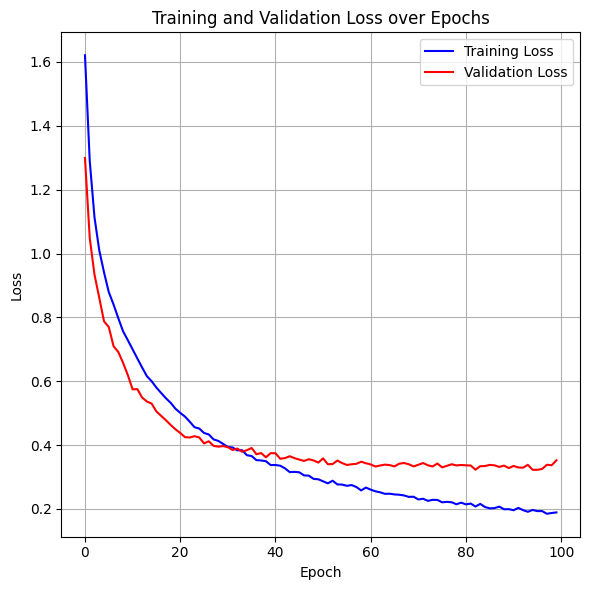

In [39]:
# 繪製損失曲線
plt.figure(figsize=(6, 6))
plt.plot(train_loss, label='Training Loss', color='b')  # 藍色，訓練損失
plt.plot(val_loss, label='Validation Loss', color='r')  # 紅色，驗證損失

# 圖片標題和軸標籤
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # 顯示圖例
plt.grid(True)  # 顯示網格線
plt.tight_layout()  # 自動調整佈局以防止標籤重疊
plt.savefig("/content/drive/MyDrive/LOSS_curve.png", dpi=300)
# plt.savefig("loss_curve.png", dpi=300)
plt.show()

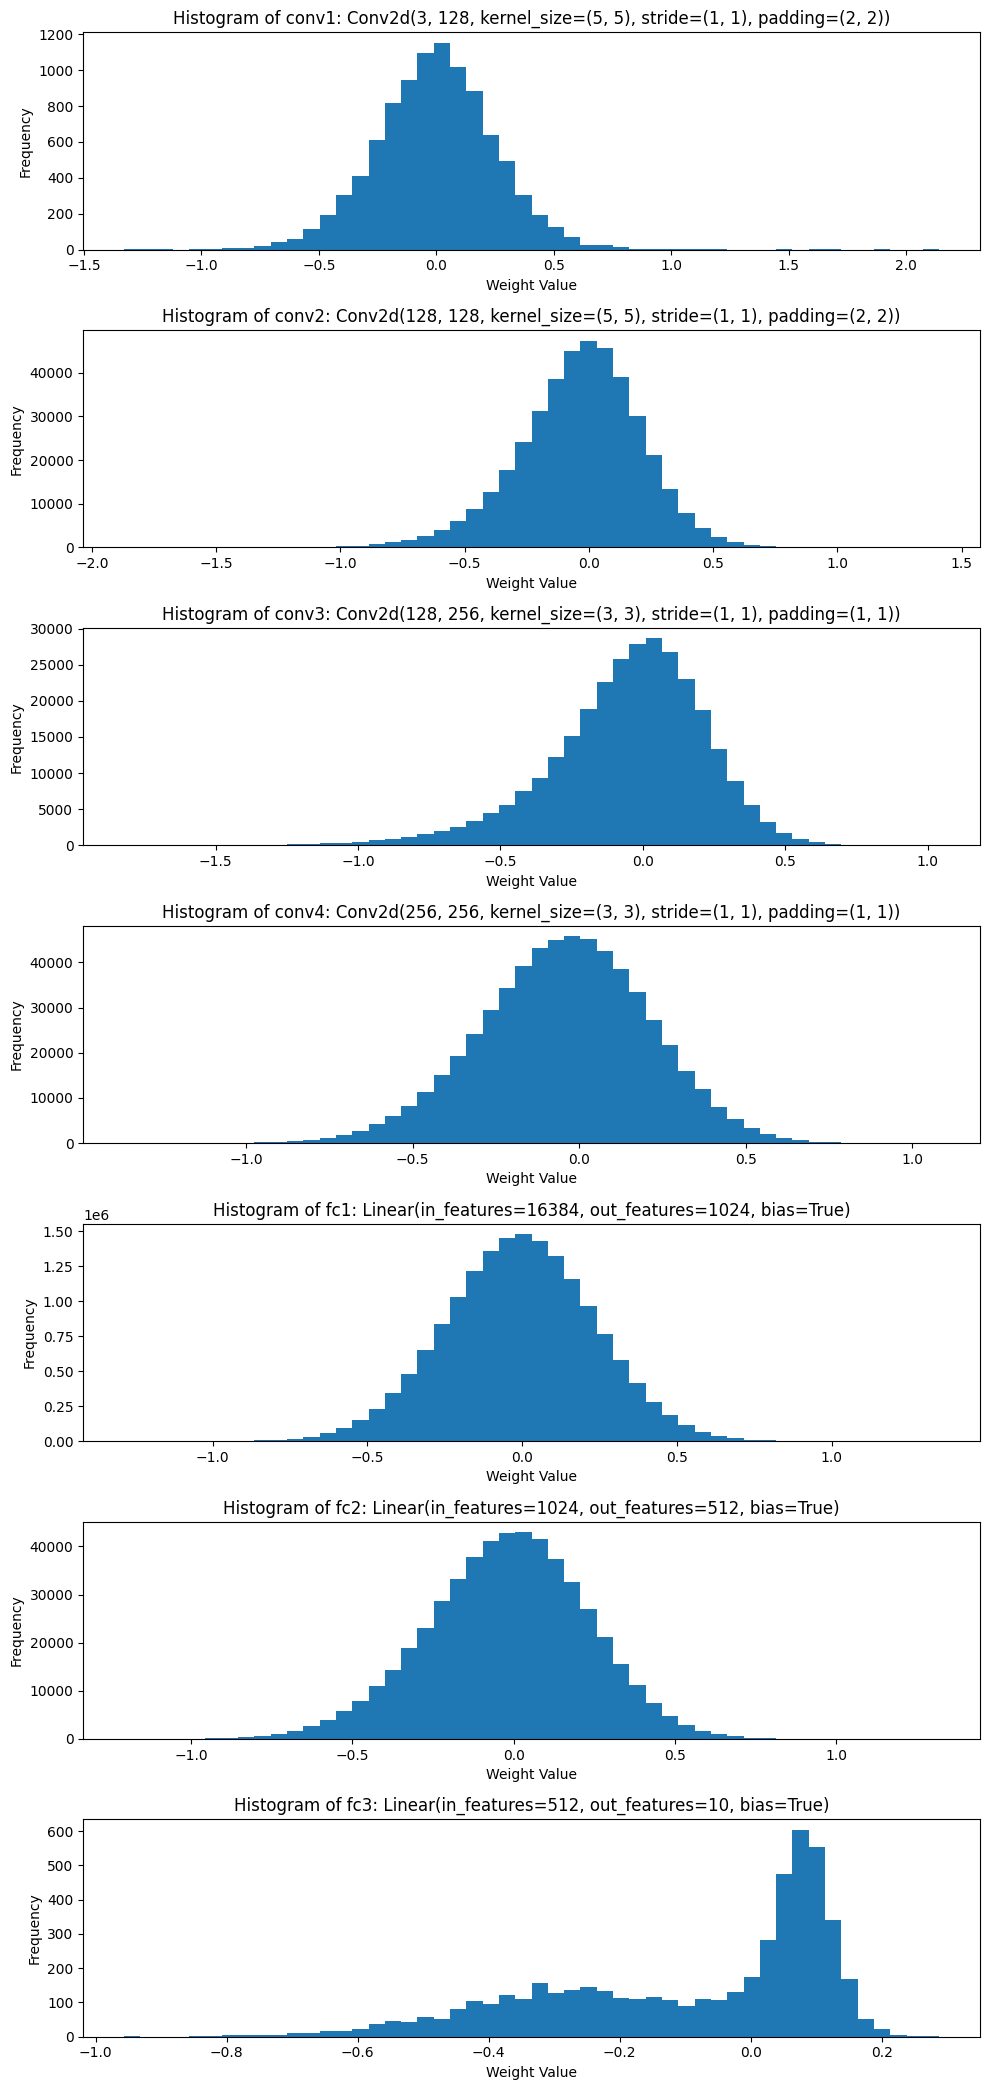

In [51]:

# 定義過濾和繪圖的函數
def plot_layer_weights(model, save_path='/content/drive/MyDrive/WEIGTHED.png'):
    # 過濾掉沒有權重的層
    layers_with_weights = [(name, layer) for name, layer in model.named_modules() if isinstance(layer, (nn.Conv2d, nn.Linear))]

    # 設置子圖的大小，並根據有權重的層來創建子圖
    fig, axes = plt.subplots(len(layers_with_weights), 1, figsize=(10, 3 * len(layers_with_weights)))

    # 如果只有一個子圖，確保 axes 是一個列表
    if len(layers_with_weights) == 1:
        axes = [axes]

    # 繪製每個層的權重直方圖
    for ax, (name, layer) in zip(axes, layers_with_weights):
        # 提取權重（忽略 biases，只繪製 weights）
        weights = layer.weight.data.cpu().numpy().flatten()  # 獲取權重並展平
        ax.hist(weights, bins=50)
        ax.set_title(f"Histogram of {name}: {layer}")  # 顯示層名稱與類型
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    # plt.savefig('weighted', dpi=300)  # 保存圖片
    plt.savefig(save_path, dpi=300)
    plt.show()

# 假設 model 是您的 CNN 模型
plot_layer_weights(model, save_path='/content/drive/MyDrive/WEIGTHED.png')


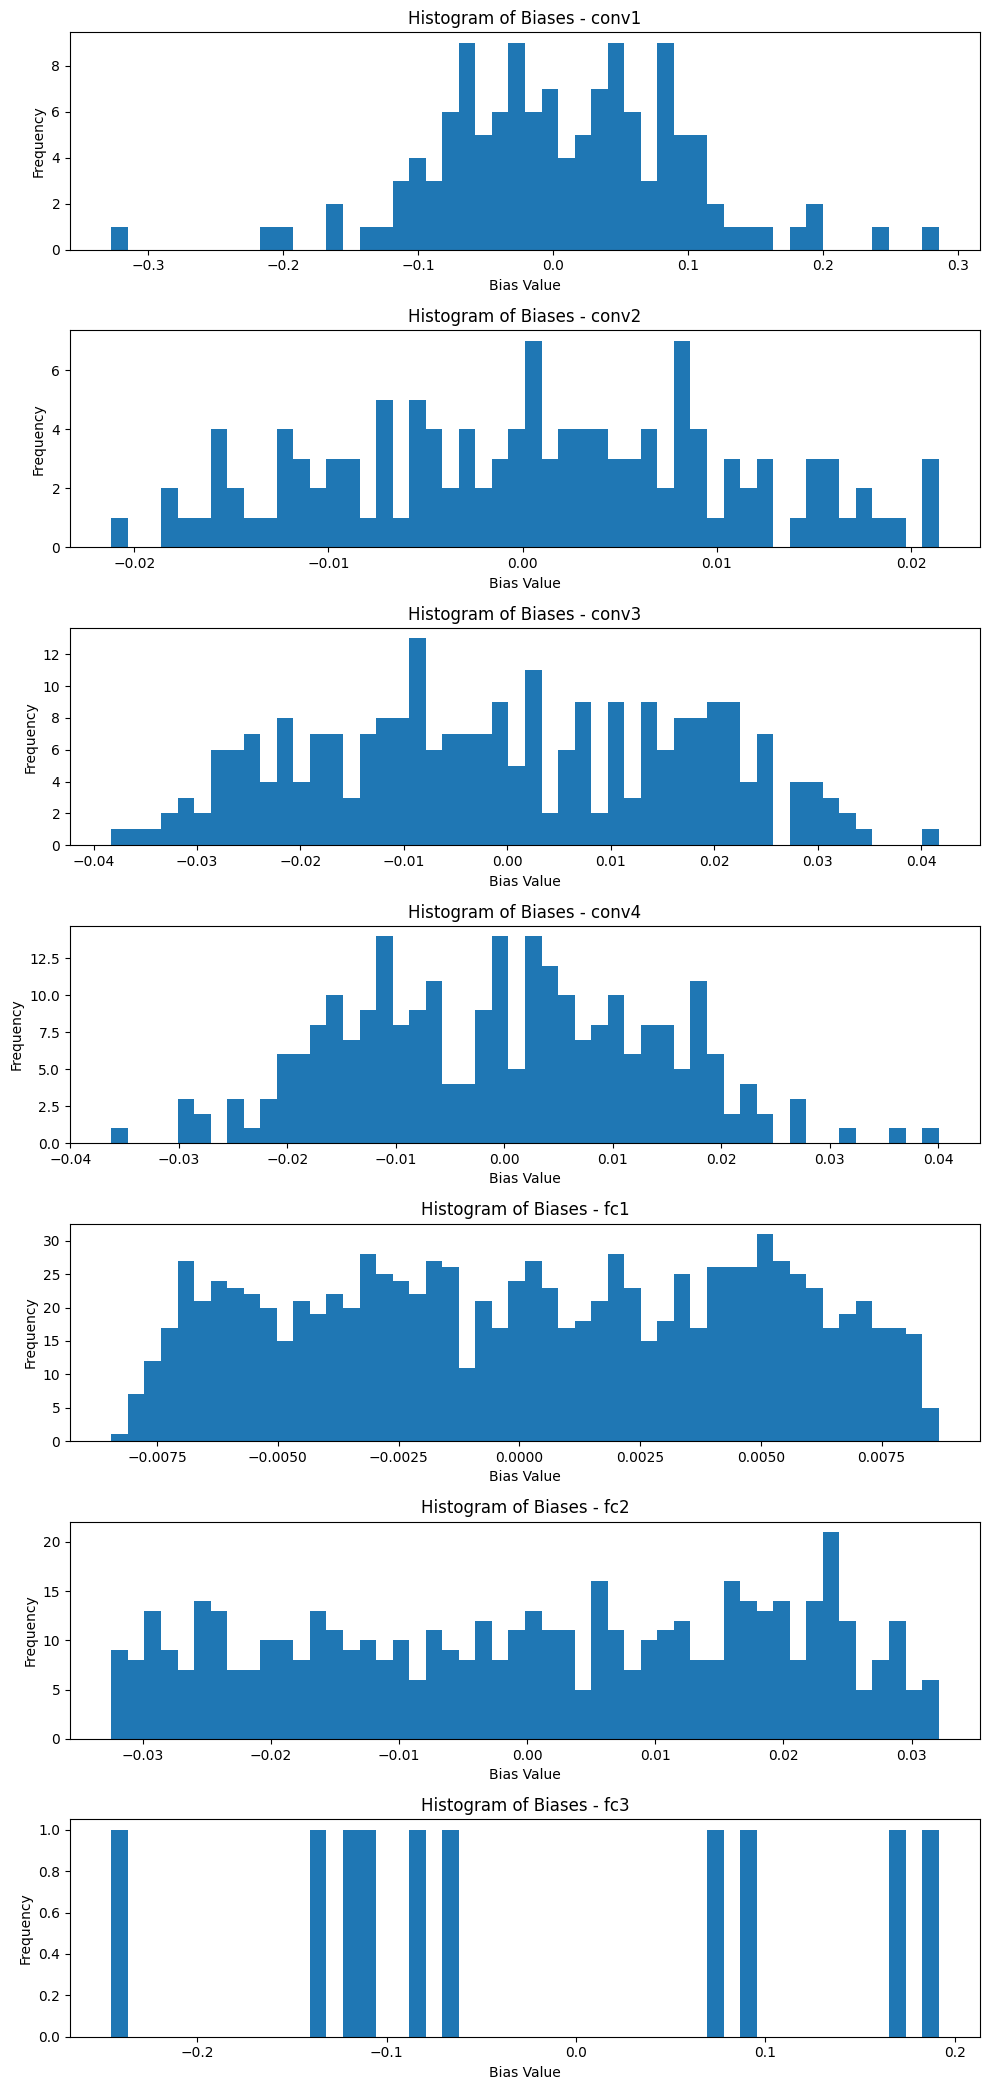

Bias histograms saved as /content/drive/MyDrive/BIAS_HISTOGRAMS.png


In [52]:
# 定義繪製偏置的函數
def plot_layer_biases(model, save_path='/content/drive/MyDrive/BIAS_HISTOGRAMS.png'):
    # 過濾出有偏置的層
    layers_with_biases = [(name, layer) for name, layer in model.named_modules() if isinstance(layer, (nn.Conv2d, nn.Linear)) and layer.bias is not None]

    # 設置子圖的大小，並根據有偏置的層來創建子圖
    fig, axes = plt.subplots(len(layers_with_biases), 1, figsize=(10, 3 * len(layers_with_biases)))

    # 如果只有一個子圖，確保 axes 是一個列表
    if len(layers_with_biases) == 1:
        axes = [axes]

    # 繪製每層的偏置直方圖
    for ax, (name, layer) in zip(axes, layers_with_biases):
        # 提取偏置並展平為一維數組
        biases = layer.bias.data.cpu().numpy().flatten()
        ax.hist(biases, bins=50)
        ax.set_title(f"Histogram of Biases - {name}")
        ax.set_xlabel('Bias Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Bias histograms saved as {save_path}")

# 假設 model 是您的 CNN 模型
plot_layer_biases(model, save_path='/content/drive/MyDrive/BIAS_HISTOGRAMS.png')

Labels:   cat  ship  ship plane  frog
Predictions:   cat  ship  ship plane  frog
Visualization saved as /content/drive/MyDrive/visualization.png


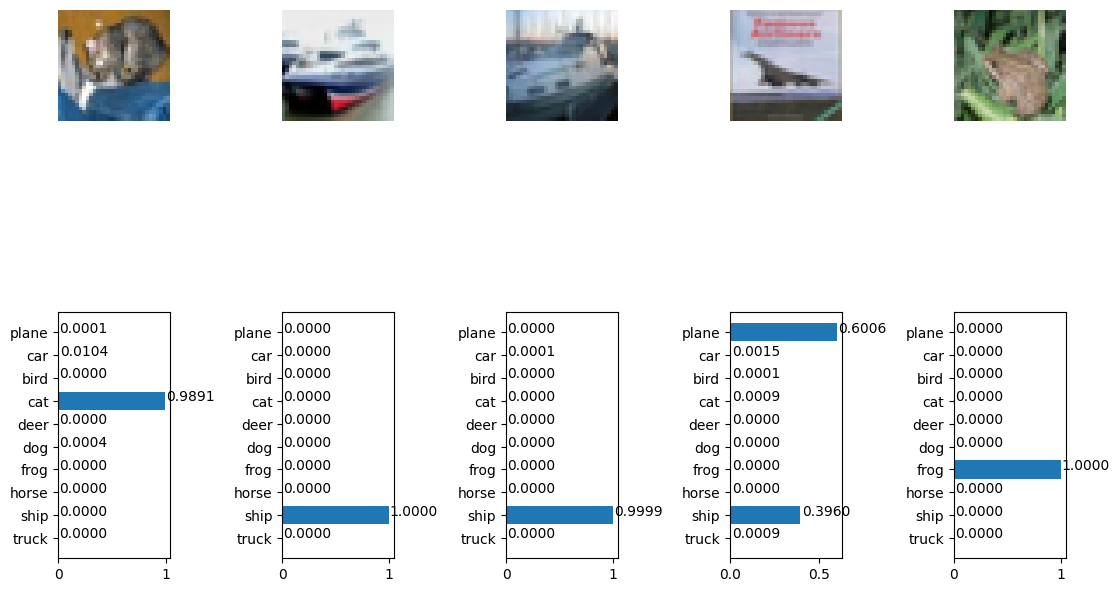

In [41]:
# 定義類別標籤
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#visualize(CNN, test_loader, classes)

visualize(model, test_loader, classes,save_path='/content/drive/MyDrive/visualization.png')

In [42]:
pred_vec = []
correct = 0
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 89.63 %


Visualization saved as /content/drive/MyDrive/missclassicfication.png


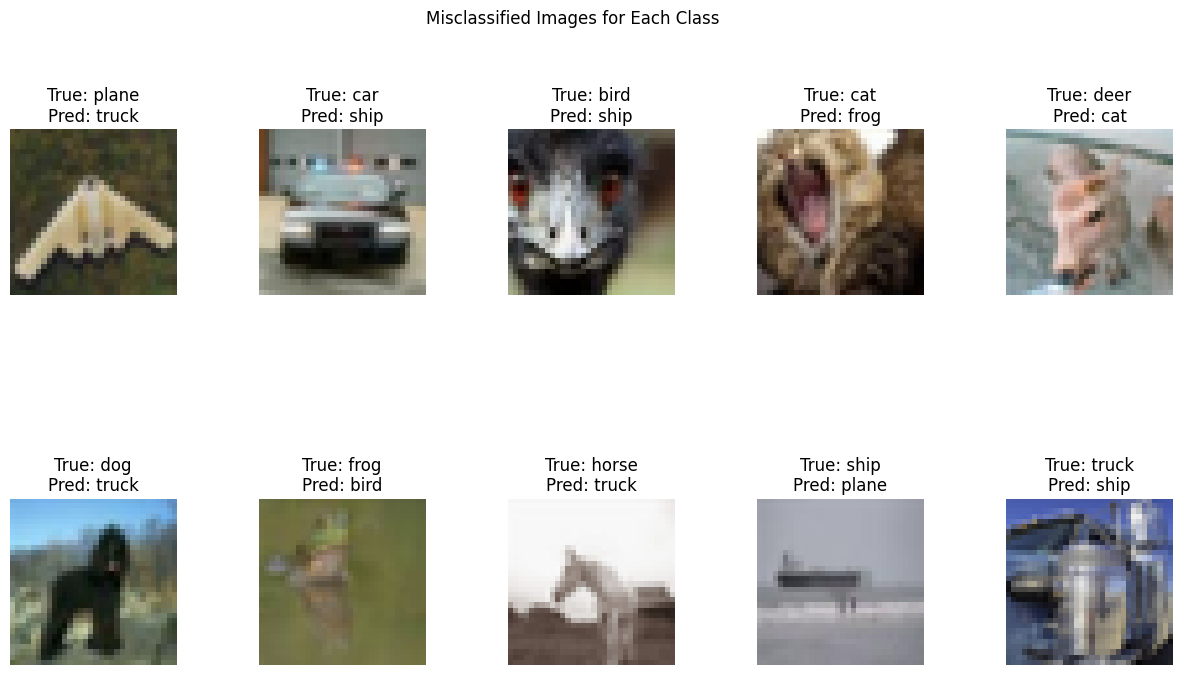

In [43]:
# 定義類別標籤
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def visualize_misclassified(model, data_loader, classes, device,save_path='/content/drive/MyDrive/missclassicfication.png'):
    model.eval()
    pred_vec = []
    ground_truth_vec = []

    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            pred_vec.append(predicted)
            ground_truth_vec.append(labels)

    pred_vec = torch.cat(pred_vec).cpu().numpy()
    ground_truth_vec = torch.cat(ground_truth_vec).cpu().numpy()

    incorrect_mask = pred_vec != ground_truth_vec
    incorrect_images = [data_loader.dataset.data[(ground_truth_vec == label) & incorrect_mask][0] for label in range(10)]
    incorrect_preds = [pred_vec[(ground_truth_vec == label) & incorrect_mask][0] for label in range(10)]

    # 繪製錯誤分類的圖片
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(incorrect_images[i])  # 顯示圖片
        ax.set_title(f"True: {classes[i]}\nPred: {classes[incorrect_preds[i]]}")
        ax.axis('off')

    plt.suptitle("Misclassified Images for Each Class")
    plt.savefig(save_path, dpi=300)
    print(f"Visualization saved as {save_path}")
    plt.show()

# 使用範例
visualize_misclassified(model, test_loader, classes, device,save_path='/content/drive/MyDrive/missclassicfication.png')

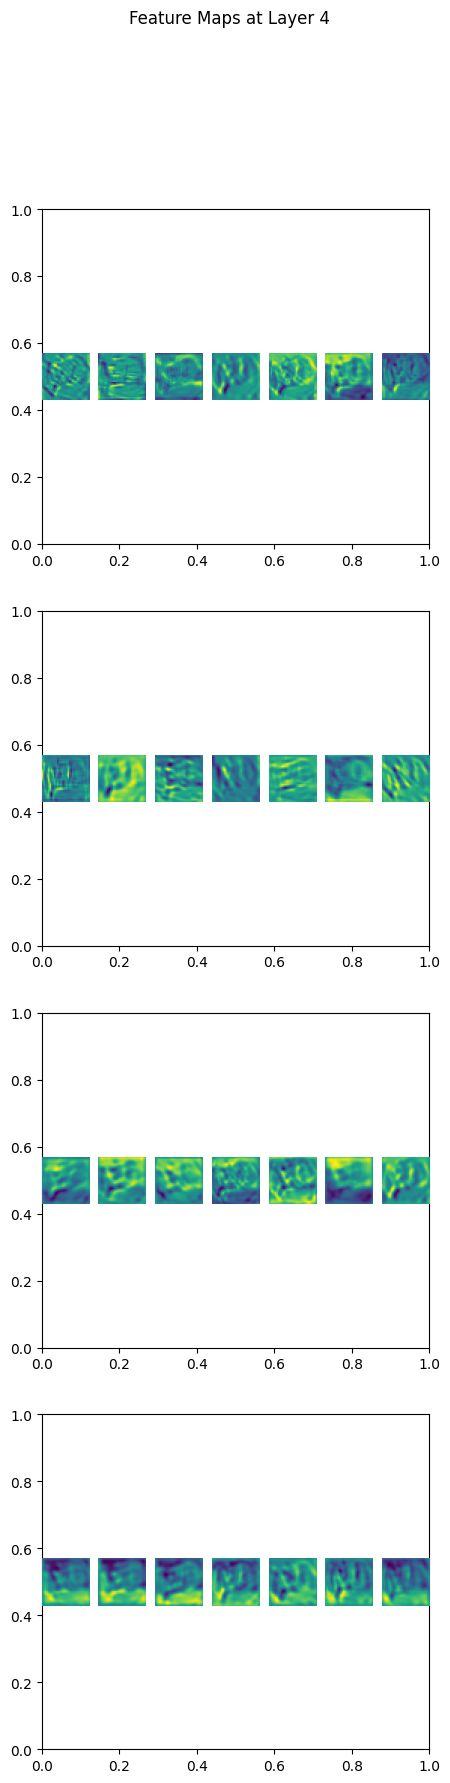

In [44]:
# 定義函數，用於可視化卷積層的特徵圖
def visualize_feature_maps(model, input_image, save_path='/content/drive/MyDrive/feature_maps.png'):
    layers = [layer for layer in model.children() if isinstance(layer, torch.nn.Conv2d)]
    feature_maps = []
    x = input_image.unsqueeze(0)  # 增加 batch 維度

    # 遍歷每一個卷積層，並計算特徵圖
    for layer in layers:
        x = layer(x)  # 進行正向傳播
        feature_maps.append(x)  # 儲存特徵圖

    # 可視化特徵圖
    num_layers = len(feature_maps)
    fig, axes = plt.subplots(num_layers, 1, figsize=(5, 5 * num_layers))

    for i, feature_map in enumerate(feature_maps):
        # 取出該層的特徵圖中的前 4 個通道
        features = feature_map[0, :7].detach().cpu()
        grid_size = features.size(0)

        # 繪製每個通道的特徵圖
        for j in range(grid_size):
            ax = fig.add_subplot(num_layers, grid_size, i * grid_size + j + 1)
            ax.imshow(features[j], cmap='viridis')
            ax.axis('off')
        plt.suptitle(f"Feature Maps at Layer {i+1}")
    plt.savefig(save_path, dpi=300)
    plt.show()


# 從 data_loader 中取得一張圖像
data_iter = iter(test_loader)
images, _ = next(data_iter)
input_image = images[0].to(device)

# 可視化模型的特徵圖

visualize_feature_maps(model, input_image, save_path='/content/drive/MyDrive/feature_maps.png')


------------------------------------------------存起來


In [33]:
# import pickle

# # 保存模型參數
# torch.save(model.state_dict(), "model.pth")
# # 保存訓練歷史紀錄
# history = {
#     'train_loss': train_loss,
#     'train_acc': train_acc,
#     'val_loss': val_loss,
#     'val_acc': val_acc,
#     'test_acc': test_acc
# }

# # 保存到檔案
# with open("training_history.pkl", "wb") as f:
#     pickle.dump(history, f)



In [34]:
#1.將文件下載到本地電腦
# from google.colab import files
# files.download("model.pth")
# files.download("training_historyCIF.pkl")


# import pickle
# from google.colab import drive
# 保存模型參數到 Google 雲端硬碟
# from google.colab import drive
# drive.mount('/content/drive')
# torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")
# print("Model parameters saved as model.pth in Google Drive")

# # 保存訓練歷史紀錄到 Google 雲端硬碟
# history = {
#     'train_loss': train_loss,
#     'train_acc': train_acc,
#     'val_loss': val_loss,
#     'val_acc': val_acc,
#     'test_acc': test_acc
# }

# with open("/content/drive/MyDrive/training_history.pkl", "wb") as f:
#     pickle.dump(history, f)
# print("Training history saved as training_history.pkl in Google Drive")  #開起來用上面的程式

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model parameters saved as model.pth in Google Drive
Training history saved as training_history.pkl in Google Drive


In [ ]:
# #從電腦本地開啟
# import torch
# import pickle
# from google.colab import files

# # 選擇並上傳文件，這將打開一個文件選擇窗口
# uploaded = files.upload()
# # 加載模型參數
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Net().to(device)
# model.load_state_dict(torch.load("model.pth"))

# # 加載訓練歷史紀錄
# with open("training_history.pkl", "rb") as f:
#     history = pickle.load(f)

# # 使用歷史紀錄
# train_loss = history['train_loss']
# train_acc = history['train_acc']
# val_loss = history['val_loss']
# val_acc = history['val_acc']
# test_acc = history['test_acc']

In [15]:
# # 載入模型參數
# model.load_state_dict(torch.load("model.pth"))

# # 載入訓練歷史紀錄
# with open("training_history.pkl", "rb") as f:
#     history = pickle.load(f)

# # 使用歷史紀錄
# train_loss = history['train_loss']
# train_acc = history['train_acc']
# val_loss = history['val_loss']
# val_acc = history['val_acc']
# test_acc = history['test_acc']

<ipython-input-15-e43813ccedf3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'model.pth'

-------------L2


In [45]:
# 定義損失函數
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_l2 = Net().to(device)
criterion = nn.CrossEntropyLoss()


# 使用 weight_decay 來進行 L2 正則化
optimizer = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=0.001)


# 執行訓練
train_loss, train_acc, val_loss, val_acc, test_acc = train(
    model_l2, epochs=100, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
    optimizer=optimizer, criterion=criterion, device=device, batch_size=64
)

Epoch 1/100 - Train Loss: 1.6195, Train Acc: 0.4073 - Val Loss: 1.3289, Val Acc: 0.5187 - Test Acc: 0.5686
Epoch 2/100 - Train Loss: 1.3332, Train Acc: 0.5200 - Val Loss: 1.1898, Val Acc: 0.5772 - Test Acc: 0.6222
Epoch 3/100 - Train Loss: 1.2219, Train Acc: 0.5664 - Val Loss: 1.0815, Val Acc: 0.6234 - Test Acc: 0.6640
Epoch 4/100 - Train Loss: 1.1548, Train Acc: 0.5943 - Val Loss: 1.0299, Val Acc: 0.6393 - Test Acc: 0.6606
Epoch 5/100 - Train Loss: 1.1149, Train Acc: 0.6097 - Val Loss: 1.0079, Val Acc: 0.6468 - Test Acc: 0.6726
Epoch 6/100 - Train Loss: 1.0790, Train Acc: 0.6240 - Val Loss: 1.0290, Val Acc: 0.6386 - Test Acc: 0.6709
Epoch 7/100 - Train Loss: 1.0473, Train Acc: 0.6326 - Val Loss: 0.9749, Val Acc: 0.6621 - Test Acc: 0.6864
Epoch 8/100 - Train Loss: 1.0121, Train Acc: 0.6498 - Val Loss: 0.9501, Val Acc: 0.6728 - Test Acc: 0.6574
Epoch 9/100 - Train Loss: 0.9892, Train Acc: 0.6582 - Val Loss: 0.8586, Val Acc: 0.7023 - Test Acc: 0.7048
Epoch 10/100 - Train Loss: 0.9685, Tr

In [47]:
import pickle
from google.colab import drive
#保存模型參數到 Google 雲端硬碟
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), "/content/drive/MyDrive/model_l2.pth")
print("Model parameters saved as model_l2.pth in Google Drive")

# 保存訓練歷史紀錄到 Google 雲端硬碟
history_l2 = {
    'train_loss': train_loss,
    'train_acc': train_acc,
    'val_loss': val_loss,
    'val_acc': val_acc,
    'test_acc': test_acc
}

with open("/content/drive/MyDrive/training_history_l2.pkl", "wb") as f:
    pickle.dump(history, f)
print("Training history saved as training_history_l2.pkl in Google Drive")  #開起來用上面的程式

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model parameters saved as model_l2.pth in Google Drive
Training history saved as training_history_l2.pkl in Google Drive


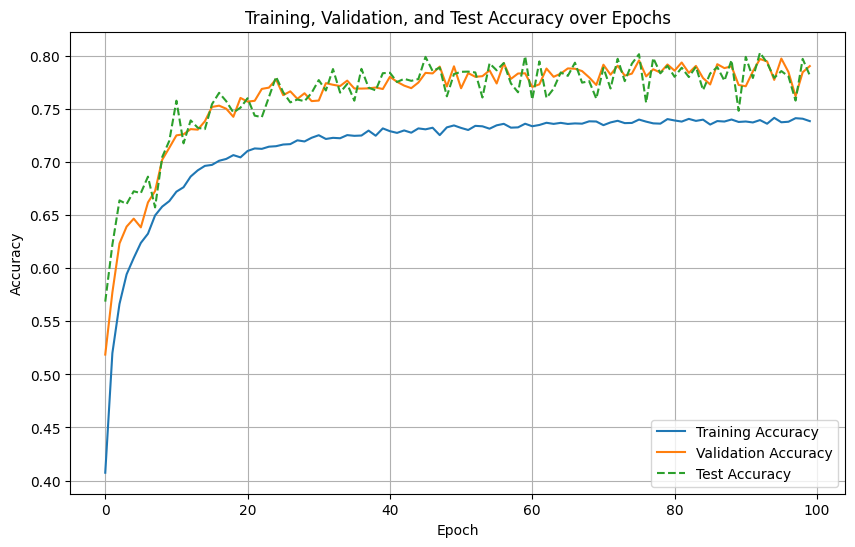

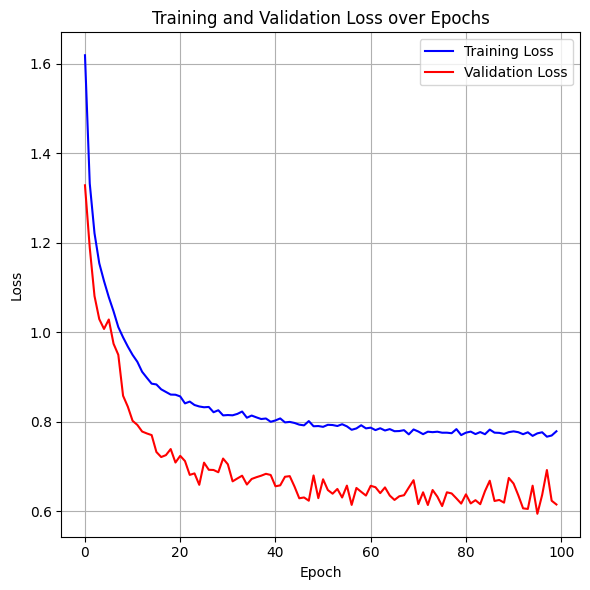

In [48]:
# 繪製準確率曲線
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(test_acc, label='Test Accuracy', linestyle='--')  # 每個 epoch 的測試準確率

plt.title('Training, Validation, and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/accuracy_curve_L2.png", dpi=300)
plt.show()



# 繪製損失曲線
plt.figure(figsize=(6, 6))
plt.plot(train_loss, label='Training Loss', color='b')  # 藍色，訓練損失
plt.plot(val_loss, label='Validation Loss', color='r')  # 紅色，驗證損失

# 圖片標題和軸標籤
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # 顯示圖例
plt.grid(True)  # 顯示網格線
plt.tight_layout()  # 自動調整佈局以防止標籤重疊
plt.savefig("/content/drive/MyDrive/LOSS_curve_L2.png", dpi=300)
plt.show()

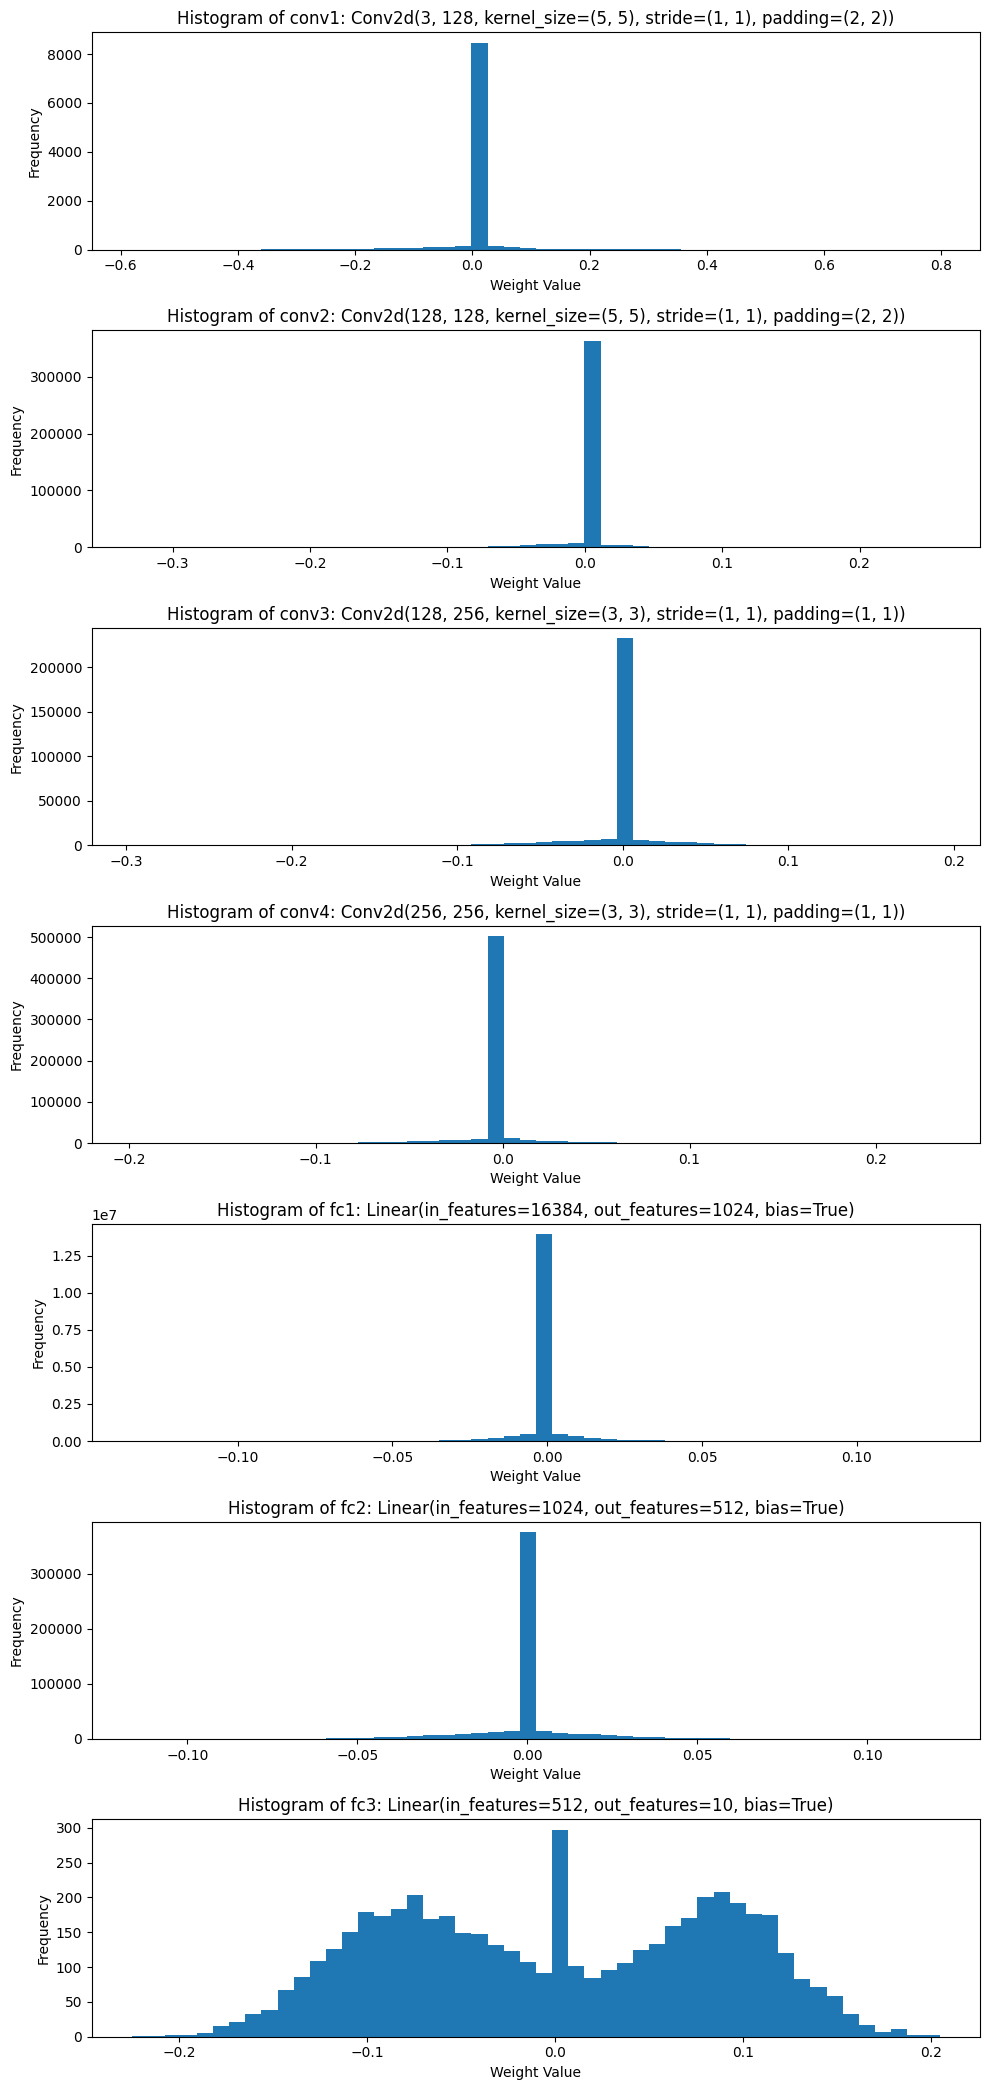

In [54]:
plot_layer_weights(model_l2, save_path='/content/drive/MyDrive/WEIGTHED_L2.png')

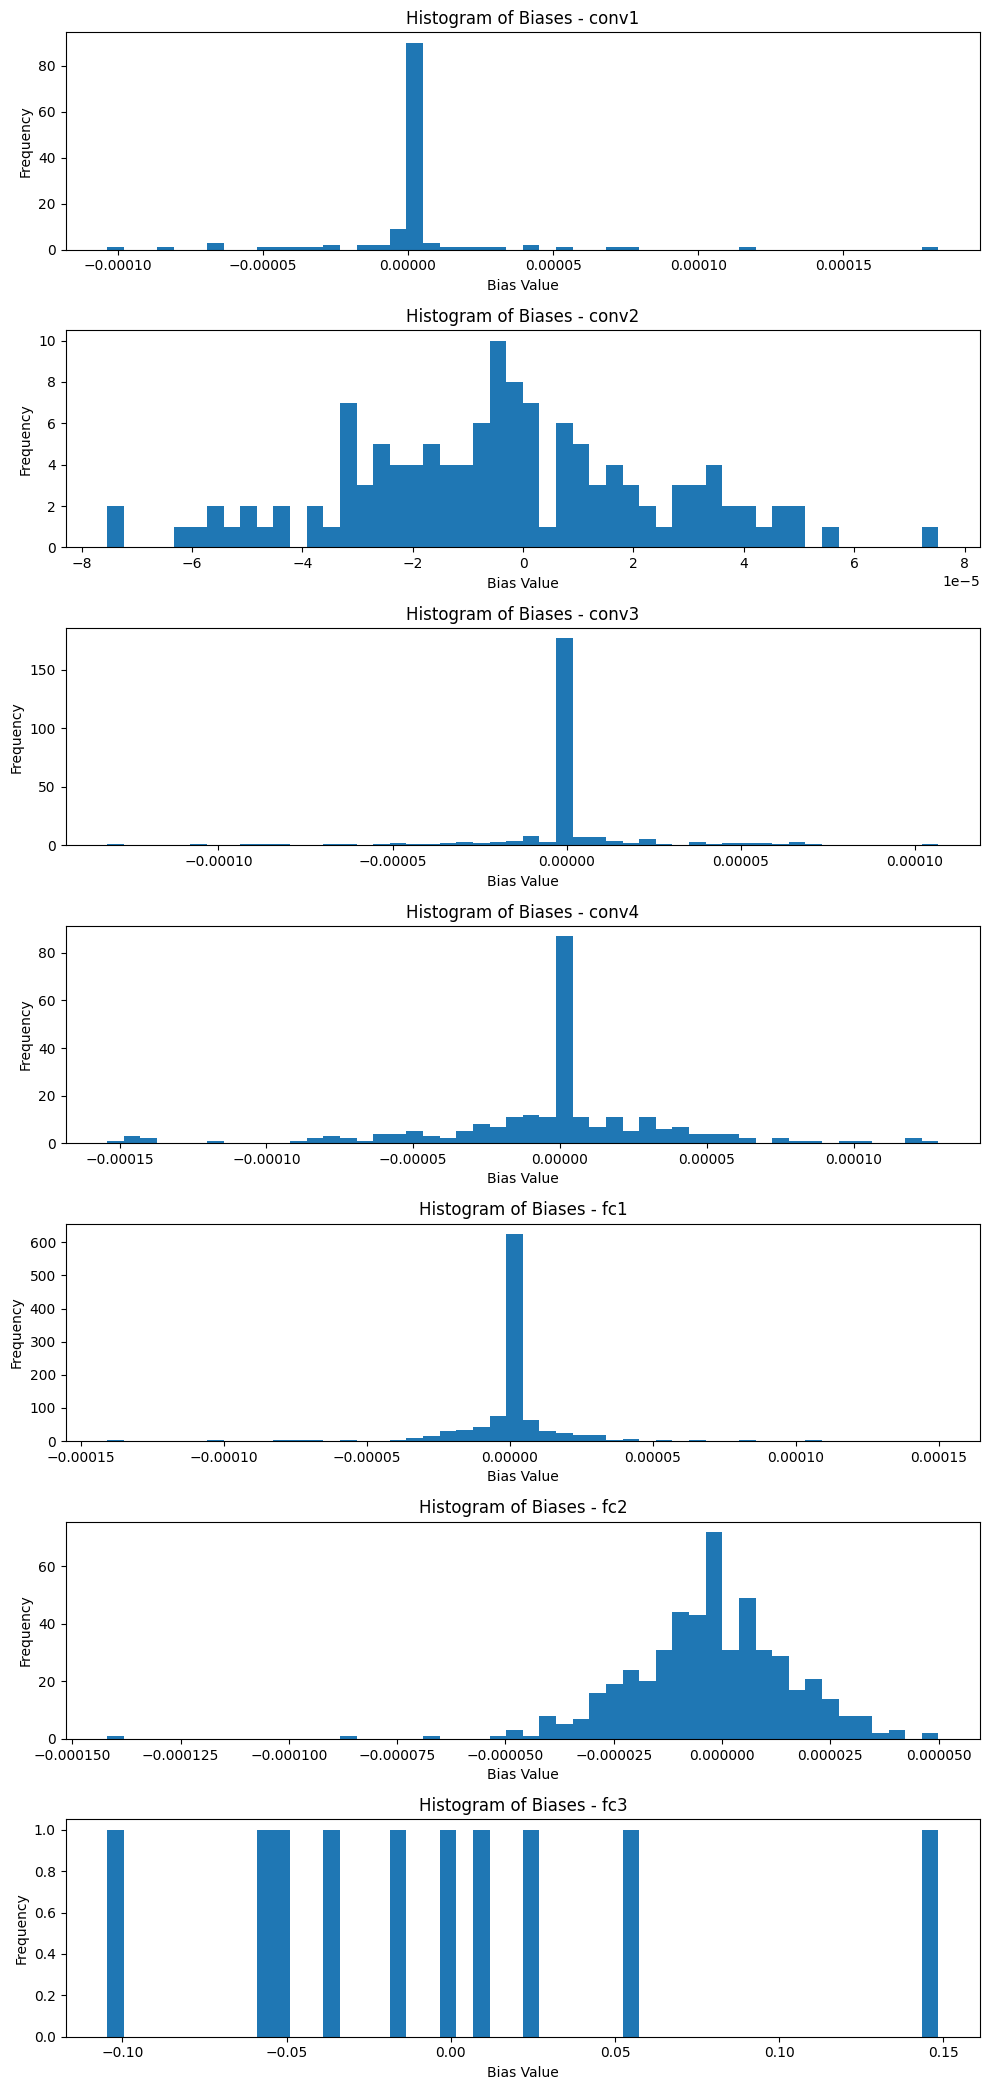

Bias histograms saved as /content/drive/MyDrive/BIAS_HISTOGRAMS_L2.png


In [53]:
plot_layer_biases(model_l2, save_path='/content/drive/MyDrive/BIAS_HISTOGRAMS_L2.png')